In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt

In [2]:
data = pd.read_csv("BBC News Train.csv")

In [3]:
data.head()

,ArticleId,Text,Category
0,1833,worldcom ex-boss launches defence lawyers defe...,business
1,154,german business confidence slides german busin...,business
2,1101,bbc poll indicates economic gloom citizens in ...,business
3,1976,lifestyle governs mobile choice faster bett...,tech
4,917,enron bosses in $168m payout eighteen former e...,business


In [4]:
data["Category"].value_countscounts()

sport            346
business         336
politics         274
entertainment    273
tech             261
Name: Category, dtype: int64

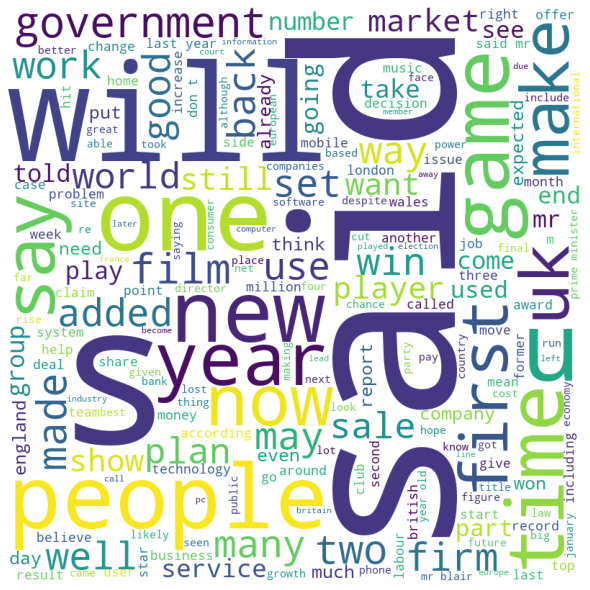

In [7]:
from wordcloud import WordCloud, STOPWORDS 
comment_words = '' 
stopwords = set(STOPWORDS) 

for val in data['Text']: 
      
    val = str(val) 
    tokens = val.split() 

    for i in range(len(tokens)): 
        tokens[i] = tokens[i].lower() 
      
    comment_words += " ".join(tokens)+" "

    
wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                stopwords = stopwords, 
                min_font_size = 10).generate(comment_words) 
                     
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show()

In [9]:
data['category_id'] = data['Category'].factorize()[0]

#View first 10 entries of category_id, as a sanity check
data['category_id'][0:10]
data.head(5)

,ArticleId,Text,Category,category_id
0,1833,worldcom ex-boss launches defence lawyers defe...,business,0
1,154,german business confidence slides german busin...,business,0
2,1101,bbc poll indicates economic gloom citizens in ...,business,0
3,1976,lifestyle governs mobile choice faster bett...,tech,1
4,917,enron bosses in $168m payout eighteen former e...,business,0


In [10]:
data.category_id.unique()

array([0, 1, 2, 3, 4], dtype=int64)

In [11]:
Cat_id_DF = data[['Category', 'category_id']].drop_duplicates().sort_values('category_id')
Cat_id_DF

,Category,category_id
0,business,0
3,tech,1
5,politics,2
6,sport,3
7,entertainment,4


In [12]:
category_to_id = dict(Cat_id_DF.values)

In [13]:
category_to_id

{'business': 0, 'tech': 1, 'politics': 2, 'sport': 3, 'entertainment': 4}

In [14]:
id_to_category = dict(Cat_id_DF[['category_id', 'Category']].values)
id_to_category

{0: 'business', 1: 'tech', 2: 'politics', 3: 'sport', 4: 'entertainment'}

In [16]:
data.groupby('Category').category_id.count()

Category
business         336
entertainment    273
politics         274
sport            346
tech             261
Name: category_id, dtype: int64

<AxesSubplot:xlabel='Category'>

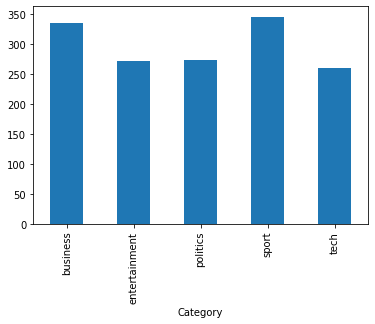

In [18]:
data.groupby('Category').category_id.count().plot.bar(ylim=0)

In [19]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', encoding='latin-1', ngram_range=(1, 2), stop_words='english')

features = tfidf.fit_transform(data.Text).toarray()
# Remaps the words in the 1490 articles in the text column of 
# data frame into features (superset of words) with an importance assigned 
# based on each words frequency in the document and across documents

labels = data.category_id

In [24]:
len(features), features.shape

(1490, (1490, 9927))

In [25]:
category_to_id.items()

dict_items([('business', 0), ('tech', 1), ('politics', 2), ('sport', 3), ('entertainment', 4)])

In [26]:
sorted(category_to_id.items())

[('business', 0),
 ('entertainment', 4),
 ('politics', 2),
 ('sport', 3),
 ('tech', 1)]

In [27]:
from sklearn.feature_selection import chi2
N = 3  # We are going to look for top 3 categories

#For each category, find words that are highly corelated to it
for Category, category_id in sorted(category_to_id.items()):
    features_chi2 = chi2(features, labels == category_id)                   # Do chi2 analyses of all items in this category
    indices = np.argsort(features_chi2[0])                                  # Sorts the indices of features_chi2[0] - the chi-squared stats of each feature
    feature_names = np.array(tfidf.get_feature_names())[indices]            # Converts indices to feature names ( in increasing order of chi-squared stat values)
    unigrams = [v for v in feature_names if len(v.split(' ')) == 1]         # List of single word features ( in increasing order of chi-squared stat values)
    bigrams = [v for v in feature_names if len(v.split(' ')) == 2]          # List for two-word features ( in increasing order of chi-squared stat values)
    print("# '{}':".format(Category))
    print("  . Most correlated unigrams:\n       . {}".format('\n       . '.join(unigrams[-N:]))) # Print 3 unigrams with highest Chi squared stat
    print("  . Most correlated bigrams:\n       . {}".format('\n       . '.join(bigrams[-N:]))) # Print 3 bigrams with highest Chi squared stat

# 'business':
  . Most correlated unigrams:
       . growth
       . bank
       . shares
  . Most correlated bigrams:
       . stock market
       . economic growth
       . analysts said
# 'entertainment':
  . Most correlated unigrams:
       . singer
       . actor
       . film
  . Most correlated bigrams:
       . won best
       . los angeles
       . box office
# 'politics':
  . Most correlated unigrams:
       . blair
       . election
       . labour
  . Most correlated bigrams:
       . prime minister
       . tony blair
       . mr blair
# 'sport':
  . Most correlated unigrams:
       . match
       . coach
       . cup
  . Most correlated bigrams:
       . grand slam
       . champions league
       . australian open
# 'tech':
  . Most correlated unigrams:
       . technology
       . software
       . users
  . Most correlated bigrams:
       . anti virus
       . mobile phones
       . mobile phone


In [28]:
features_chi2

(array([0.13345481, 0.01563765, 0.00108776, ..., 0.00812363, 0.15434356,
        0.120306  ]),
 array([0.71487652, 0.9004835 , 0.97368962, ..., 0.92818297, 0.69441858,
        0.72870284]))

In [29]:
from sklearn.manifold import TSNE

# Sampling a subset of our dataset because t-SNE is computationally expensive
SAMPLE_SIZE = int(len(features) * 0.3)
np.random.seed(0)
indices = np.random.choice(range(len(features)), size=SAMPLE_SIZE, replace=False)          # Randomly select 30 % of samples
projected_features = TSNE(n_components=2, random_state=0).fit_transform(features[indices]) # Array of all projected features of 30% of Randomly chosen samples 
projected_features.shape

(447, 2)

In [30]:
my_id = 0 # Select a category_id
projected_features[(labels[indices] == my_id).values]

array([[  2.7825692 ,  15.441475  ],
       [ -7.058563  ,  24.184692  ],
       [  1.2346098 ,  30.813969  ],
       [  9.460215  ,  25.276316  ],
       [ 12.25645   , -19.00246   ],
       [  6.5474377 ,  21.924099  ],
       [-14.644814  ,  17.591993  ],
       [  8.358559  ,  21.490097  ],
       [ 15.427329  ,  25.961151  ],
       [ -2.569004  ,  26.837566  ],
       [-11.073658  ,  23.655098  ],
       [  1.5741967 ,  25.727413  ],
       [ 10.370158  ,  11.785584  ],
       [ -2.226906  ,  22.24362   ],
       [  9.479474  ,  27.850174  ],
       [  2.7283478 ,  24.337986  ],
       [ -6.00327   ,  23.208319  ],
       [  7.298235  ,  23.776398  ],
       [  0.46313453,  19.073269  ],
       [-11.076589  ,  16.818588  ],
       [ 18.201622  ,  20.108046  ],
       [ -4.7741823 ,  16.597239  ],
       [  1.3453362 ,  30.60072   ],
       [ -5.342315  ,  21.719809  ],
       [  5.2986484 ,  23.935171  ],
       [ -7.5837154 ,  19.794918  ],
       [ -3.3005261 ,  18.652798  ],
 

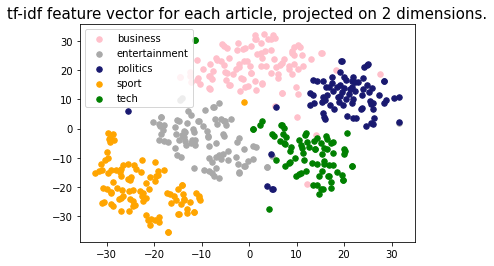

In [31]:
colors = ['pink', 'green', 'midnightblue', 'orange', 'darkgrey']

# Find points belonging to each category and plot them
for category, category_id in sorted(category_to_id.items()):
    points = projected_features[(labels[indices] == category_id).values]
    plt.scatter(points[:, 0], points[:, 1], s=30, c=colors[category_id], label=category)
plt.title("tf-idf feature vector for each article, projected on 2 dimensions.",
          fontdict=dict(fontsize=15))
plt.legend()

In [32]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB

from sklearn.model_selection import cross_val_score


models = [
    RandomForestClassifier(n_estimators=200, max_depth=100, random_state=0),
    MultinomialNB(),
    LogisticRegression(random_state=30),
]

In [33]:
CV = 5  # Cross Validate with 5 different folds of 20% data ( 80-20 split with 5 folds )

#Create a data frame that will store the results for all 5 trials of the 3 different models
cv_df = pd.DataFrame(index=range(CV * len(models)))
entries = [] # Initially all entries are empty

In [36]:
#For each Algorithm 
for model in models:
    model_name = model.__class__.__name__
  # create 5 models with different 20% test sets, and store their accuracies
    accuracies = cross_val_score(model, features, labels, scoring='accuracy', cv=CV)
  # Append all 5 accuracies into the entries list ( after all 3 models are run, there will be 3x5 = 15 entries)
    for fold_idx, accuracy in enumerate(accuracies):
        entries.append((model_name, fold_idx, accuracy))

In [39]:
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])

In [40]:
cv_df

,model_name,fold_idx,accuracy
0,RandomForestClassifier,0,0.939597
1,RandomForestClassifier,1,0.939597
2,RandomForestClassifier,2,0.973154
3,RandomForestClassifier,3,0.963087
4,RandomForestClassifier,4,0.963087
5,MultinomialNB,0,0.969799
6,MultinomialNB,1,0.959732
7,MultinomialNB,2,0.983221
8,MultinomialNB,3,0.979866
9,MultinomialNB,4,0.969799


<AxesSubplot:xlabel='model_name', ylabel='accuracy'>

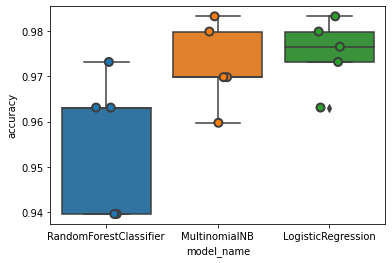

In [41]:
import seaborn as sns

sns.boxplot(x='model_name', y='accuracy', data=cv_df)
sns.stripplot(x='model_name', y='accuracy', data=cv_df, 
              size=8, jitter=True, edgecolor="gray", linewidth=2)

In [42]:
cv_df.groupby('model_name').accuracy.mean()

model_name
LogisticRegression        0.975168
MultinomialNB             0.972483
RandomForestClassifier    0.955705
Name: accuracy, dtype: float64

In [44]:
from sklearn.model_selection import train_test_split

model = LogisticRegression(random_state=0)

#Split Data 
X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(features, labels, data.index, test_size=0.20, random_state=42)

#Train Algorithm
model.fit(X_train, y_train)

# Make Predictions
y_pred_proba = model.predict_proba(X_test)
y_pred = model.predict(X_test)

Text(0.5, 15.0, 'Predicted')

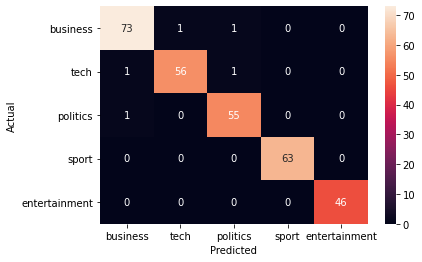

In [47]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

conf_mat = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_mat, annot=True, fmt='d',
                xticklabels=Cat_id_DF.Category.values, yticklabels=Cat_id_DF.Category.values)
plt.ylabel('Actual')
plt.xlabel('Predicted')

In [52]:
from IPython.display import display

for predicted in Cat_id_DF.category_id:
    
    for actual in Cat_id_DF.category_id:
        if predicted != actual and conf_mat[actual, predicted] >= 2:
            print("'{}' predicted as '{}' : {} examples.".format(Cat_id_DF[actual], id_to_category[predicted], conf_mat[actual, predicted]))
        display(data.loc[indices_test[(y_test == actual) & (y_pred == predicted)]]['Text'])
        print('')

1090    us retail sales surge in december us retail sa...
231     rich grab half colombia poor fund half of the ...
730     russia wto talks  make progress  talks on russ...
1484    hyundai to build new india plant south korea s...
1145    fannie mae  should restate books  us mortgage ...
                              ...                        
1395    worldcom director admits lying the former chie...
1447    us prepares for hybrid onslaught sales of hybr...
771     chinese exports rise 25% in 2004 exports from ...
1040    mexican in us send $16bn home mexican labourer...
1144    us crude prices surge above $53 us crude price...
Name: Text, Length: 73, dtype: object

571    pc ownership to  double by 2010  the number of...
Name: Text, dtype: object

962    hatfield executives go on trial engineering fi...
Name: Text, dtype: object

Series([], Name: Text, dtype: object)

Series([], Name: Text, dtype: object)

1384    brussels raps mobile call charges the european...
Name: Text, dtype: object

774     online commons to spark debate online communit...
420     piero gives rugby perspective bbc sport unveil...
427     casual gaming to  take off  games aimed at  ca...
1489    santy worm makes unwelcome visit thousands of ...
1488    apple ipod family expands market apple has exp...
1074    eu software patent law faces axe the european ...
309     freeze on anti-spam campaign a campaign by lyc...
1438    google s toolbar sparks concern search engine ...
428     microsoft gets the blogging bug software giant...
605     seamen sail into biometric future the luxury c...
124     smart search lets art fans browse if you don t...
485     t-mobile bets on  pocket office  t-mobile has ...
429     broadband challenges tv viewing the number of ...
1305    microsoft releases bumper patches microsoft ha...
1010    security warning over  fbi virus  the us feder...
1464    broadband set to revolutionise tv bt is starti...
1388    software watching while you work software that...
629     digita

Series([], Name: Text, dtype: object)

Series([], Name: Text, dtype: object)

Series([], Name: Text, dtype: object)

1309    saudi ministry to employ women women will be e...
Name: Text, dtype: object

710    ink helps drive democracy in asia the kyrgyz r...
Name: Text, dtype: object

297     howard taunts blair over splits tony blair s f...
271     fox attacks blair s tory  lies  tony blair lie...
322     blair pledges unity to labour mps tony blair h...
918     tory expert denies defeatism the conservatives...
529     talks aim to avert pension strike talks aimed ...
1233    bnp leader nick griffin arrested the leader of...
67      tories outlining policing plans local communit...
168     blair labour s longest-serving pm tony blair h...
1187    baron kinnock makes lords debut former labour ...
1053    howard unveils tory asylum plans tory plans to...
843     poll idols  face first hurdles vote for me - i...
907     chancellor rallies labour voters gordon brown ...
620     cabinet anger at brown cash raid ministers are...
123     debate needed  on donations cap a cap on donat...
1423    blair prepares to name poll date tony blair is...
894     gurkhas to help tsunami victims britain has of...
471     mps demand  budget leak  answers ministers hav...
1258    kilroy

Series([], Name: Text, dtype: object)

Series([], Name: Text, dtype: object)

Series([], Name: Text, dtype: object)

Series([], Name: Text, dtype: object)

Series([], Name: Text, dtype: object)

1108    parker misses england clash tom shanklin will ...
584     williams stays on despite dispute matt william...
1165    wilkinson to miss ireland match england will h...
1443    unclear future for striker baros liverpool for...
591     harinordoquy suffers france axe number eight i...
                              ...                        
394     bosvelt optimistic over new deal manchester ci...
712     moore questions captaincy brian moore believes...
1201    english clubs make euro history all four of en...
812     sella wants michalak recall former france cent...
1318    chelsea denied by james heroics a brave defens...
Name: Text, Length: 63, dtype: object

Series([], Name: Text, dtype: object)

Series([], Name: Text, dtype: object)

Series([], Name: Text, dtype: object)

Series([], Name: Text, dtype: object)

Series([], Name: Text, dtype: object)

941     wal-mart is sued over rude lyrics the parents ...
1393    ring of fire hit co-writer dies merle kilgore ...
938     shark tale dvd is us best-seller oscar-nominat...
342     oscars steer clear of controversy the oscars n...
1457    global release for japan hit film oscar-winnin...
405     ten-year tragedy of missing manic richey edwar...
270     brookside actress keaveney dies actress anna k...
1052    john peel replacement show begins the permanen...
244     spector facing more legal action music produce...
430     pop band busted to  take a break  chart-toppin...
614     berlin cheers for anti-nazi film a german movi...
220     moreno debut makes oscar mark catalina sandino...
560     joy division story to become film the life of ...
782     sideways dominates spirit awards the comedy si...
1327    vera drake leads uk oscar hopes mike leigh s f...
44      obituary: dame alicia markova dame alicia mark...
788     lee to create new film superhero comic book ve...
1191    potter

In [53]:
from sklearn.feature_selection import chi2

N = 5
for Category, category_id in sorted(category_to_id.items()):
    indices = np.argsort(model.coef_[category_id])   # This time using the model co-eficients / weights
    feature_names = np.array(tfidf.get_feature_names())[indices]
    unigrams = [v for v in reversed(feature_names) if len(v.split(' ')) == 1][:N]
    bigrams = [v for v in reversed(feature_names) if len(v.split(' ')) == 2][:N]
    print("# '{}':".format(Category))
    print("  . Top unigrams:\n       . {}".format('\n       . '.join(unigrams)))
    print("  . Top bigrams:\n       . {}".format('\n       . '.join(bigrams)))

# 'business':
  . Top unigrams:
       . bank
       . firm
       . shares
       . company
       . market
  . Top bigrams:
       . chief executive
       . stock market
       . analysts said
       . economic growth
       . said statement
# 'entertainment':
  . Top unigrams:
       . film
       . music
       . singer
       . star
       . band
  . Top bigrams:
       . box office
       . los angeles
       . new york
       . big brother
       . film festival
# 'politics':
  . Top unigrams:
       . labour
       . government
       . mr
       . election
       . blair
  . Top bigrams:
       . mr blair
       . prime minister
       . tony blair
       . general election
       . mr brown
# 'sport':
  . Top unigrams:
       . match
       . win
       . game
       . cup
       . season
  . Top bigrams:
       . year old
       . australian open
       . world cup
       . champions league
       . grand slam
# 'tech':
  . Top unigrams:
       . computer
       . users
   

In [54]:
test_df = pd.read_csv("BBC News Test.csv")

In [55]:
test_df.head()

,ArticleId,Text
0,1018,qpr keeper day heads for preston queens park r...
1,1319,software watching while you work software that...
2,1138,d arcy injury adds to ireland woe gordon d arc...
3,459,india s reliance family feud heats up the ongo...
4,1020,boro suffer morrison injury blow middlesbrough...


In [56]:
test_features = tfidf.transform(test_df.Text.tolist())

Y_pred = model.predict(test_features)

In [57]:
Y_pred_name =[]
for cat_id in Y_pred :
    Y_pred_name.append(id_to_category[cat_id])

In [59]:
submission = pd.DataFrame({
        "ArticleId": test_df["ArticleId"],
        "Category": Y_pred_name
    })


In [60]:
submission.to_csv('submission_BBC_NEWS_Classification.csv', index=False)